# Process mining

For å kunne utføre prosessoppdaging må datasettet inneholde følgende tre typer informasjon:
* *Saks-ID - en unik identifikator for en enhet som går gjennom prosessen. Et vanlig eksempel kan være brukerens unike ID, selv om mange muligheter er gyldige (det avhenger av brukssaken).*

* *Hendelse - et trinn i prosessen, enhver aktivitet som er en del av prosessen vi analyserer.*

* *Tidsstempel - brukes til evaluering av ytelse og bestemmelse av rekkefølgen på hendelser, kan være tidspunktet da brukeren skrev inn / ut av den gitte hendelsen (eller begge).*

I tillegg kan vi inkludere mer detaljert informasjon som ressurser, land, brukersegment, etc. Ved å utnytte tilleggsinformasjon er vi i stand til å utføre en mye mer detaljert analyse.

In [21]:
# Import av nødvendige pakker
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

from pm4py.objects.conversion.process_tree import converter as pt_converter

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Les inn data
df = pd.read_csv("running-example.csv")

# Konvertere til timestamp
df["time:timestamp"]= pd.to_datetime(df["time:timestamp"])
log = log_converter.apply(df)

# Glims av data
df.head()

,Activity,Costs,Resource,case:concept:name,case:creator,concept:name,org:resource,time:timestamp
0,register request,50,Pete,3,Fluxicon Nitro,register request,Pete,2010-12-30 14:32:00+01:00
1,examine casually,400,Mike,3,Fluxicon Nitro,examine casually,Mike,2010-12-30 15:06:00+01:00
2,check ticket,100,Ellen,3,Fluxicon Nitro,check ticket,Ellen,2010-12-30 16:34:00+01:00
3,decide,200,Sara,3,Fluxicon Nitro,decide,Sara,2011-01-06 09:18:00+01:00
4,reinitiate request,200,Sara,3,Fluxicon Nitro,reinitiate request,Sara,2011-01-06 12:18:00+01:00


In [3]:
#Datatyper
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype                               
---  ------             --------------  -----                               
 0   Activity           42 non-null     object                              
 1   Costs              42 non-null     int64                               
 2   Resource           42 non-null     object                              
 3   case:concept:name  42 non-null     int64                               
 4   case:creator       42 non-null     object                              
 5   concept:name       42 non-null     object                              
 6   org:resource       42 non-null     object                              
 7   time:timestamp     42 non-null     datetime64[ns, pytz.FixedOffset(60)]
dtypes: datetime64[ns, pytz.FixedOffset(60)](1), int64(2), object(5)
memory usage: 2.8+ KB


### Alpha miner 

Alpha Miner er en av de mest kjente algoritmene for prosessoppdagelse.
Kort sagt, algoritmen skanner sporene (sekvenser i hendelsesloggen) for å sortere relasjoner og bygger fotavtrykkmatrisen.
Deretter konverterer den matrisen til et ** Petri-nett (graf) **. 


Bruk av Alpha Miner resulterer i følgende:

* *en Petri-nettmodell der alle overgangene er synlige, unike og tilsvarer de klassifiserte hendelsene.*
* *den første merkingen -  beskriver statusen til Petri net-modellen når kjøringen starter.* 
* *den endelige merkingen -  beskriver statusen til Petri-nettmodellen når utførelsen avsluttes.*

Prosessmodeller uttrykt ved bruk av Petri-nett deler en veldefinert semantikk: utførelsen av prosessen starter fra hendelsene som inngår i den første merkingen og avsluttes ved hendelsene som inngår i den endelige merkingen.


Noen av begrensingene til algoritmen:

* *klarer ikke håndtere loops med lengde på en eller to*
* *usynlige og dupliserte oppgaver kan ikke oppdages*
* *den oppdagede modellen er kanskje ikke en god fit*
* *den takler ikke støy bra*

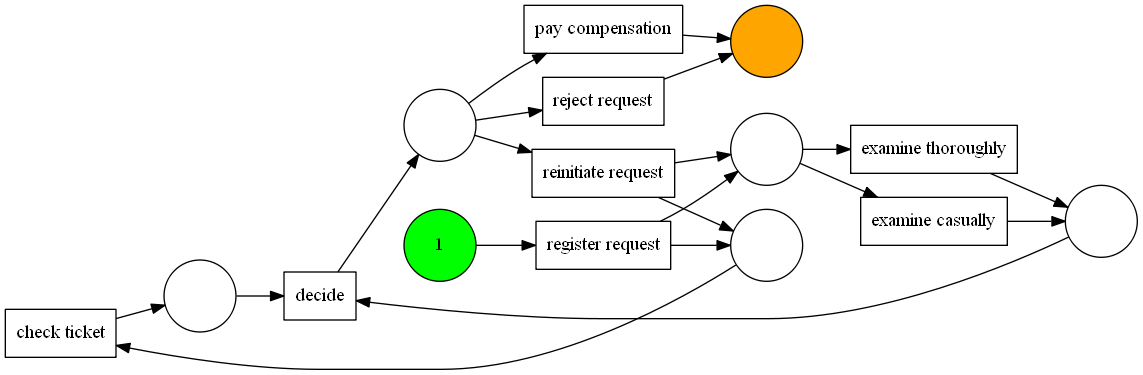

In [4]:
#Initier alpha miner
net, initial_marking, final_marking = alpha_miner.apply(log)

# illustrer
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)




***Den grønne sirkelen representerer den første merkingen i data, mens den oransje den siste merkingen. 
Ved å bruke det første tilfellet av datasettet kan vi følge sporet slik: registrer forespørsel -> undersøker grundig -> sjekk "ticket" -> avgjør -> avvis forespørsel.*** 

For å gi litt mer informasjon på proseskartet, kan vi legge til informasjon om hyppigheten av hendelsene. 






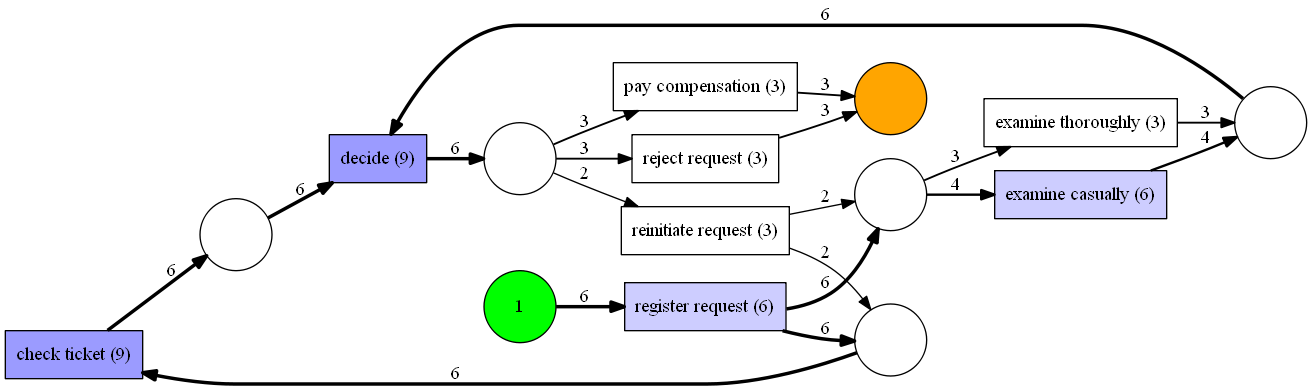

In [5]:
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}


gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

pn_visualizer.view(gviz)

Her observer vi de hyppigste stegene som er tatt i de ulike sekvensene i event-loggen.






Det er en forbedret versjon av Alpha Miner kalt Alpha + Miner, som i tillegg kan håndtere loops med henholdvis lengde en og to.


### Directly-Follows Graph


En annen type prosessmodelle er Directly-Follows Graph. 

I denne type modeller representerer nodene hendelsene fra loggen, mens målrettede kanter forbinder nodene 
hvis det er minst ett spor i loggen der kildehendelsen følges av målhendelsen.

Disse målrettede kantene fungerer fint sammen med noen ekstra metrics, for eksempel:
* *frekvens - antall ganger kildehendelsen etterfølges av målhendelsen.*
* *ytelse - en slags aggregering, for eksempel den gjennomsnittlige tiden som har gått mellom de to hendelsene.*


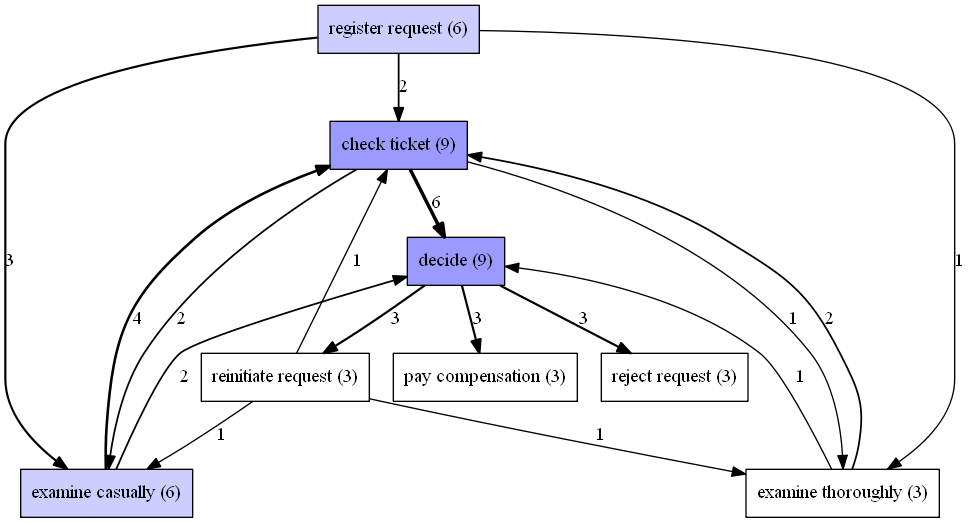

In [7]:
dfg = dfg_discovery.apply(log)

gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

I grafen observert la vi til frekvensen på toppen av de målrettede kantene. 
Vi kan se at denne grafen er vesentlig forskjellig fra Petri-nettet hentet fra Alpha Miner. 
Det er som en konsekvens av at denne typen graf viser alle sammenhengene og ikke prøver å finne noen regler som eventen følger.


Alternativt kan vi dekorere kantene ved å bruke ytelsesberegningen i stedet. 
Ved å bruke PERFORMANCE-varianten viser vi gjennomsnittlig tid som har gått mellom de to nodene.

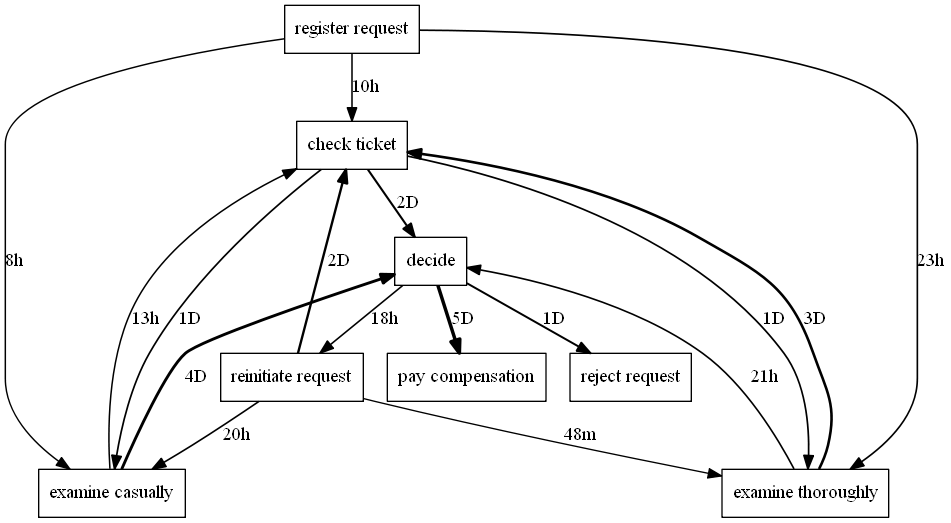

In [8]:
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)

gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)

### Heurstic miner

Heuristics Miner er en videre forbedring av Alpha Miner-algoritmen og fungerer på en Directly-Follows Graph. 

Fordelen ved bruk av denne algoritmen er at den gir en måte å håndtere støy på, samt det å finne vanlige konstruksjoner. 
Outputen av algoritmen er et Heuristics Net - et objekt som inneholder både aktivitetene og forholdet mellom dem. 
--> https://www.futurelearn.com/courses/process-mining/0/steps/15639

Merk: Heuristics Net kan konverteres til et Petri-nett.


Noen av egenskapene til algoritmen:
* *tar frekvens i betraktning*
* *oppdager korte løkker og hopper over hendelser*
* *garanterer ikke at den oppdagede modellen vil være sunn*

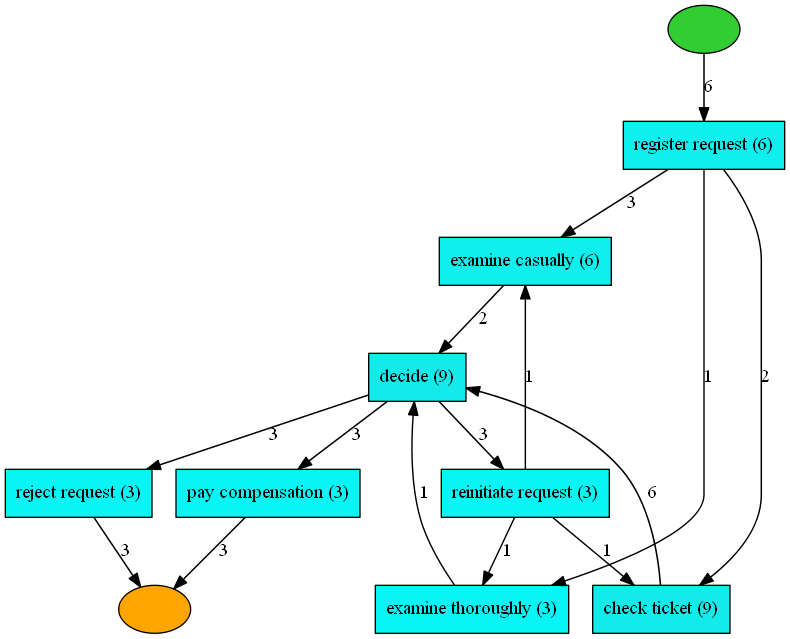

In [9]:
heu_net = heuristics_miner.apply_heu(log)

gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

Tolkningen av grafen er veldig lik Directly-Follows Graph. Vi kan også se at forbindelsene ligner strømmen visualisert av Alpha Miners Petri-nett. 

Det er verdt å nevne at formen på Heuristics Net er sterkt avhengig av settet med hyperparametere i algoritmen.


La oss nå generere et Petri-nett basert på Heuristics Miner.

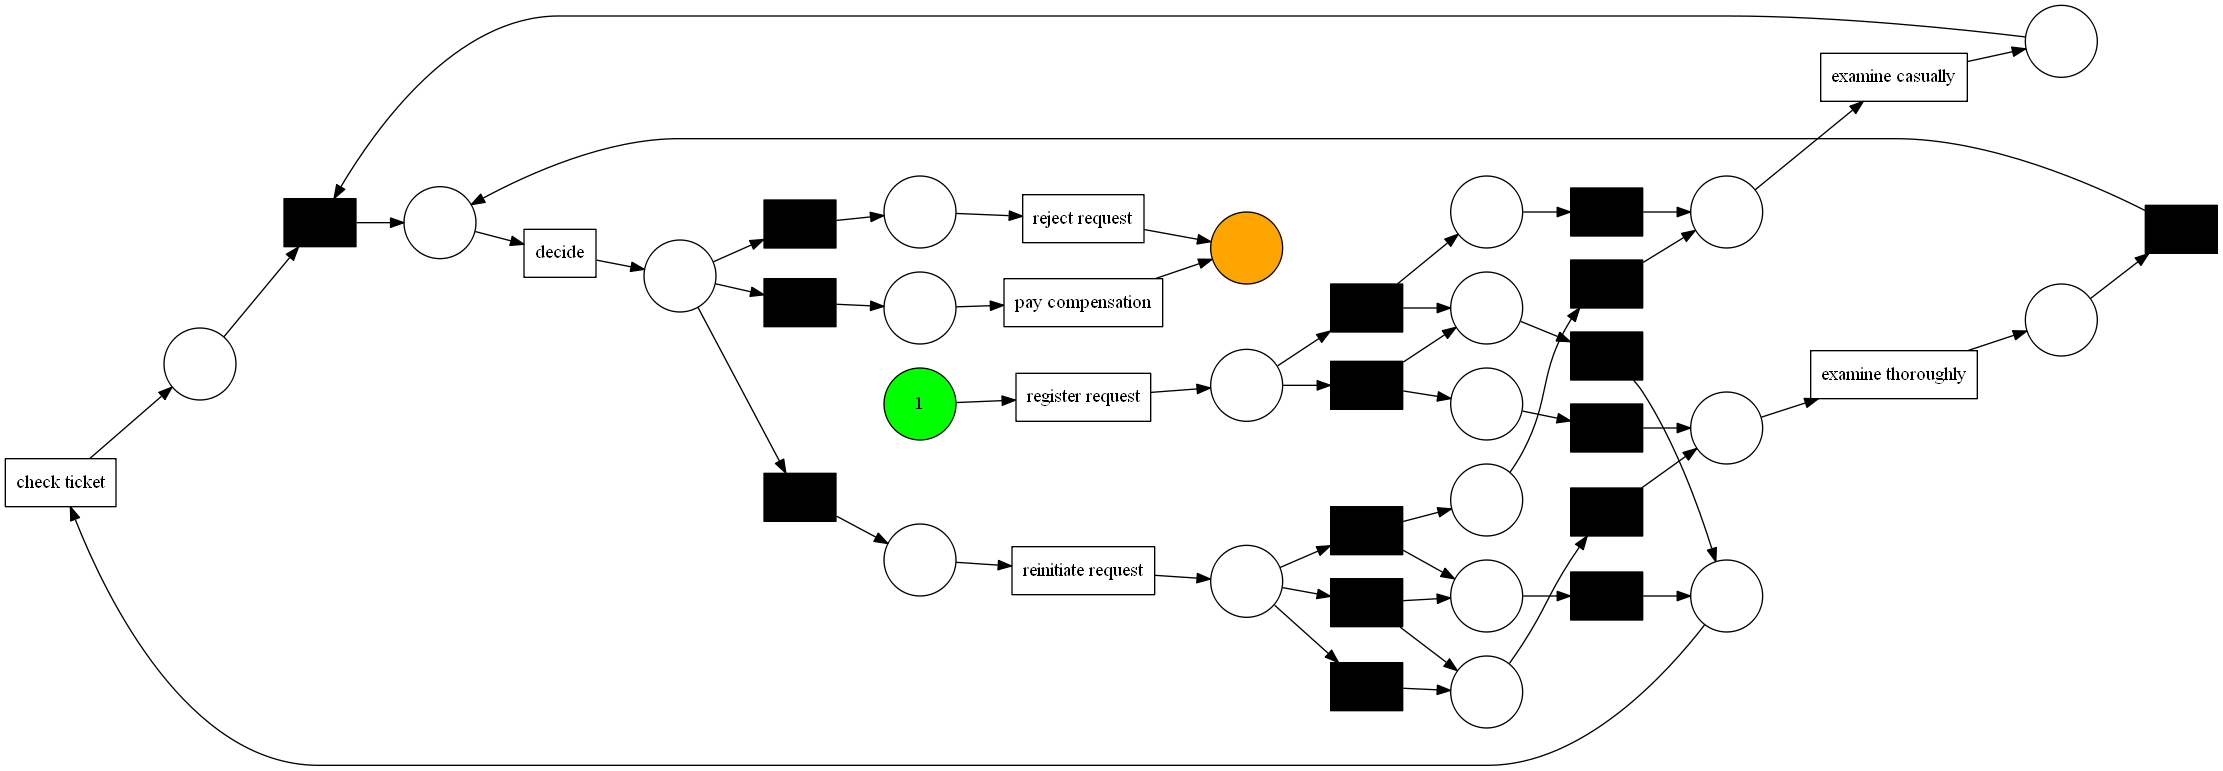

In [10]:
net, im, fm = heuristics_miner.apply(log)

gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)

### Inductive Miner
Inductive Miner er ansett en ytterligere forbedring av både Alpha Miner og Heuristics Miner. Den største forskjellen er at den garanterer en soliditet med gode treningsverdier.


Den underliggende ideen er å finne en fremtredende splittelse i hendelsesloggen (det er forskjellige typer splitter: sekvensiell, parallell, samtidig og loop). Etter å ha funnet denne splitten går algoritmen tilbake på underloggene (funnet ved å bruke splitten), til en basissak blir identifisert. 

Inductive Miner fungerer ikke på Petri-nett, men på prosesstrær (vi kan konvertere dem til Petri-nett). Følgende video beskriver intuitivt hvordan algoritmen fungerer og hva som er forskjellen mellom et Petri-nett og prosesstreet: https://www.futurelearn.com/courses/process-mining/0/steps/15642

Det er flere varianter av algoritmen, en av dem - IMDFc - unngår rekursjon på underloggene til fordel for å bruke Directly Follows graph

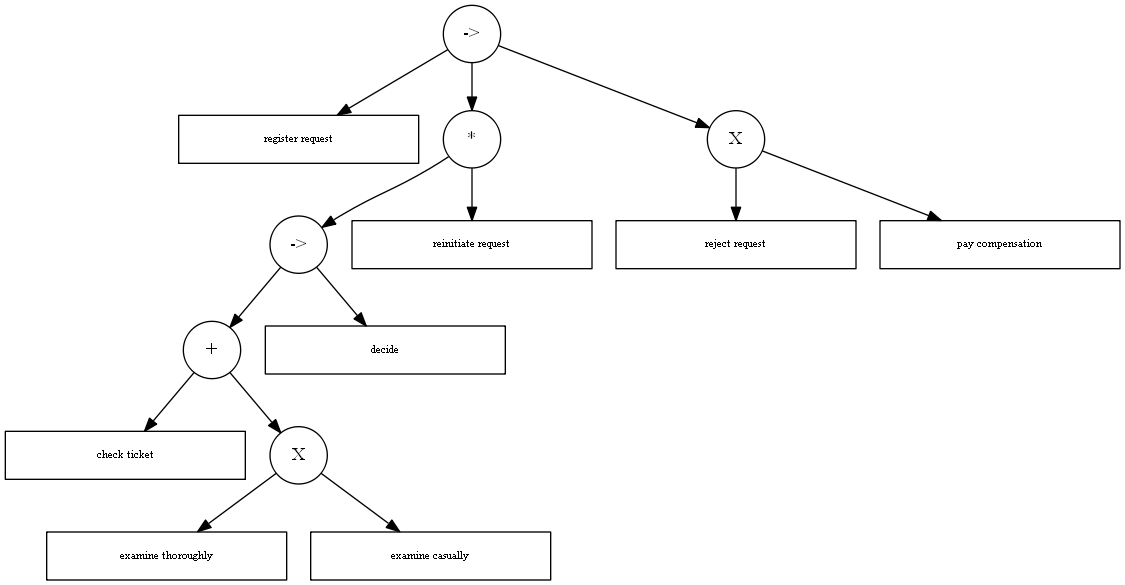

In [11]:
tree = inductive_miner.apply_tree(log)

gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)

###### hvor **->** er sekvensoperator, **X** er det eksklusive valget og * er loopen. Videre konverterer vi prosesstreet til et mer kjent Petri-nett.

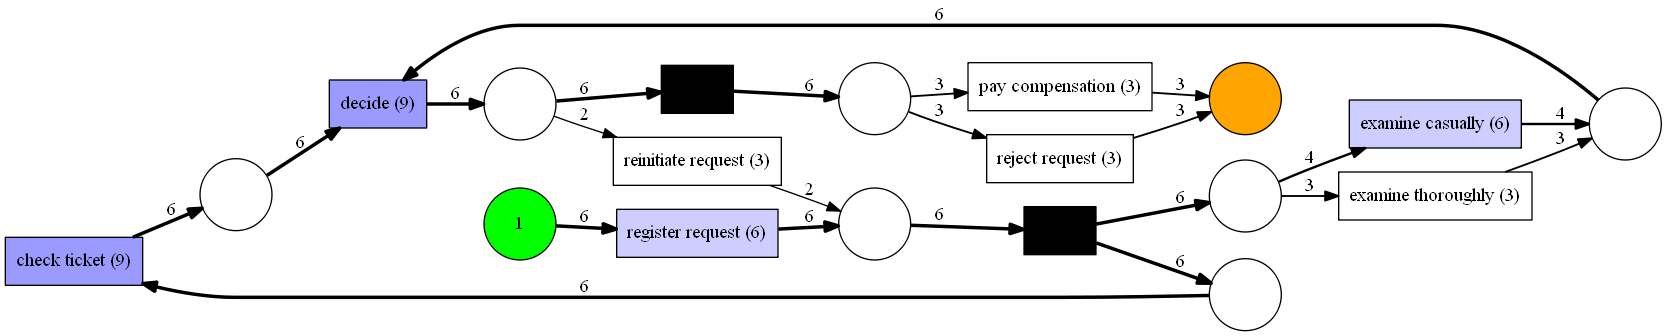

In [12]:
# Konvertere prosesstreet til et petri net
net, initial_marking, final_marking = pt_converter.apply(tree)

# alternativt, bruke inductive_miner til å lage et petri nett fra scratch
# net, initial_marking, final_marking = inductive_miner.apply(log)


parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)
pn_visualizer.view(gviz)

## .... FORTSETTELSE FØLGER

#### Alternativ metode

In [22]:
from pm4py.objects.log.adapters.pandas import csv_import_adapter as csv_importer
df = csv_importer.import_dataframe_from_path("running-example.csv")
df.head()

,Activity,Costs,Resource,case:concept:name,case:creator,concept:name,org:resource,time:timestamp
0,register request,50,Pete,3,Fluxicon Nitro,register request,Pete,2010-12-30 13:32:00+00:00
1,examine casually,400,Mike,3,Fluxicon Nitro,examine casually,Mike,2010-12-30 14:06:00+00:00
2,check ticket,100,Ellen,3,Fluxicon Nitro,check ticket,Ellen,2010-12-30 15:34:00+00:00
3,decide,200,Sara,3,Fluxicon Nitro,decide,Sara,2011-01-06 08:18:00+00:00
4,reinitiate request,200,Sara,3,Fluxicon Nitro,reinitiate request,Sara,2011-01-06 11:18:00+00:00


In [23]:
# pre-prossesering av log objekter: beholder kun saker/eventer av interesse
from pm4py.algo.filtering.pandas.end_activities import end_activities_filter as pd_end_activities_filter
filtered_df = pd_end_activities_filter.apply(df, ["pay compensation"])
print(len(df), len(filtered_df), len(df.groupby("case:concept:name")), len(filtered_df.groupby("case:concept:name")))

42 19 6 3


In [24]:
# Hvordan konvertere df til en log
from pm4py.objects.conversion.log import factory as log_conv_factory
log = log_conv_factory.apply(df)
print(len(log))

6


In [25]:
# apply a discovery algorithm (IMDFb) to the EventLog object
from pm4py.algo.discovery.inductive import factory as inductive_miner
# discovers an accepting Petri net
net, im, fm = inductive_miner.apply(df)

In [26]:
# appliser en discovery algoritme (IMDFb) på df
from pm4py.algo.discovery.inductive import factory as inductive_miner
# identifiserer et akseptabelt Petri net 
net, im, fm = inductive_miner.apply(df)

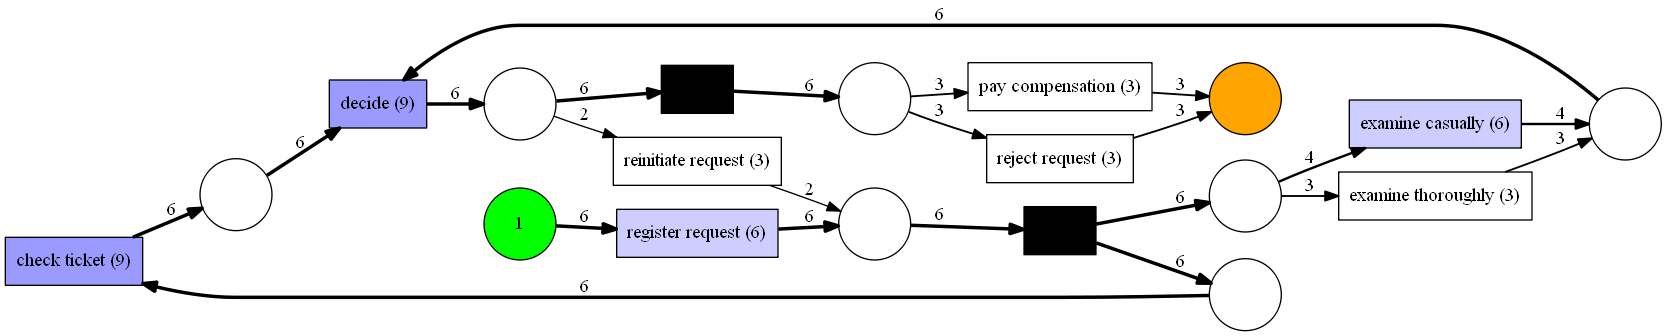

In [27]:

# Visualiser basert på frekvens/antall
from pm4py.visualization.petrinet import factory as pn_vis_factory
gviz = pn_vis_factory.apply(net, im, fm, variant="frequency", log=log)
pn_vis_factory.view(gviz)

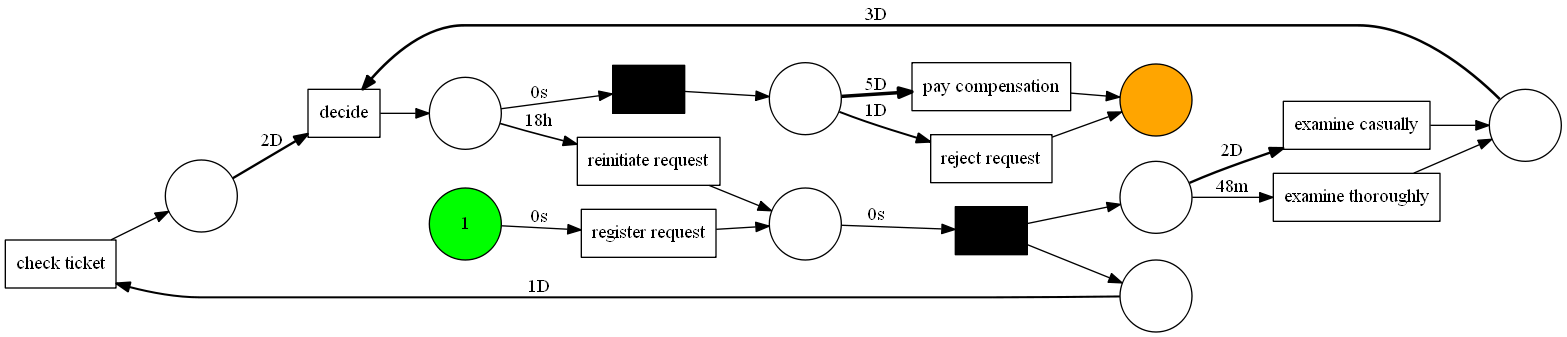

In [28]:

# Visualiser basert på tid
from pm4py.visualization.petrinet import factory as pn_vis_factory
gviz = pn_vis_factory.apply(net, im, fm, variant="performance", log=log)
pn_vis_factory.view(gviz)

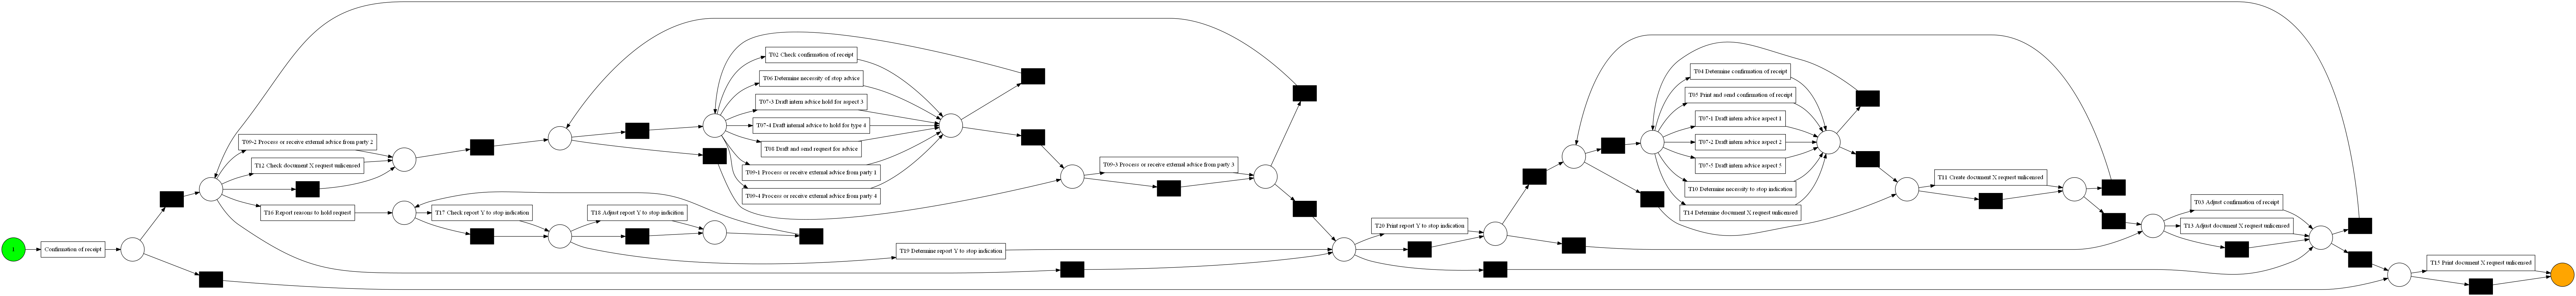

In [29]:
#Tilføye en mer kompleks log


from pm4py.objects.log.adapters.pandas import csv_import_adapter as csv_importer
df = csv_importer.import_dataframe_from_path("receipt.csv")
log = log_conv_factory.apply(df)
from pm4py.algo.discovery.inductive import factory as inductive_miner

net, im, fm = inductive_miner.apply(log)

from pm4py.visualization.petrinet import factory as pn_vis_factory
gviz = pn_vis_factory.apply(net, im, fm)
pn_visualizer.save(gviz, "inductive_miner_recipt.png")
pn_vis_factory.view(gviz)


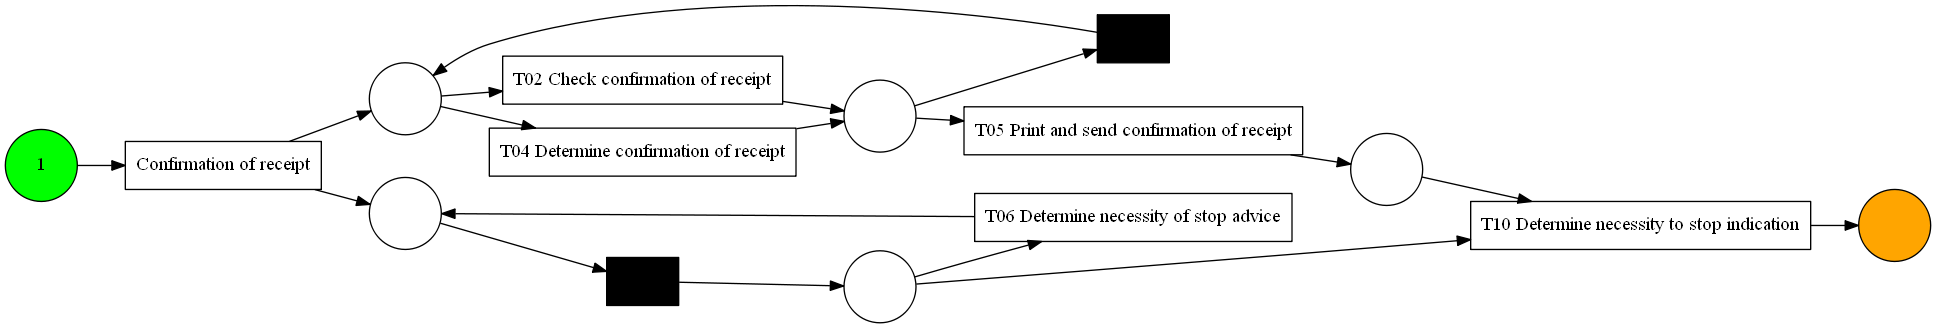

In [30]:

# appliser automatisk filtrering!
# Hent en logg med bare mainstream atferd
from copy import deepcopy
from pm4py.algo.filtering.log.auto_filter import auto_filter
filtered_log = auto_filter.apply_auto_filter(deepcopy(log))
# oppdag modell, på filtrert log - enklere
from pm4py.algo.discovery.inductive import factory as inductive_miner
net, im, fm = inductive_miner.apply(filtered_log)
from pm4py.visualization.petrinet import factory as pn_vis_factory
gviz = pn_vis_factory.apply(net, im, fm)
pn_vis_factory.view(gviz)

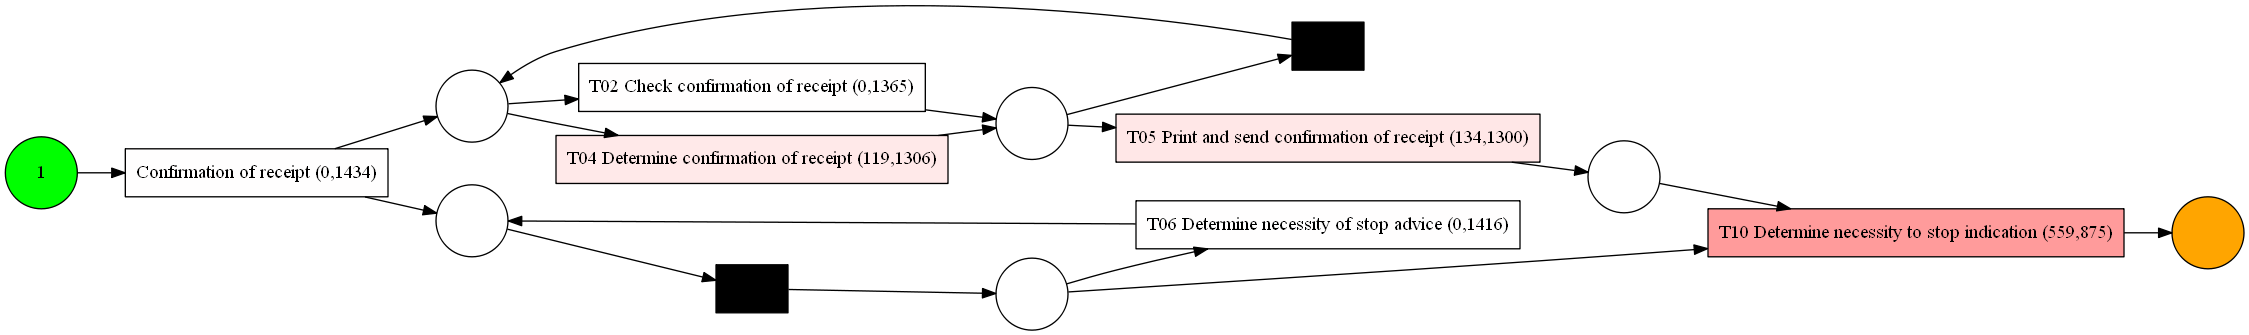

In [31]:

# Observer avvik
from pm4py.algo.conformance.alignments import factory as align_factory
alignments = align_factory.apply(log, net, im, fm, parameters={"ret_tuple_as_trans_desc": True})
from pm4py.visualization.petrinet.util import alignments_decoration
decorations = alignments_decoration.get_alignments_decoration(net, im, fm, log=log)
from pm4py.visualization.petrinet import factory as pn_vis_factory
gviz = pn_vis_factory.apply(net, im, fm, aggregated_statistics=decorations, variant="alignments")
pn_vis_factory.view(gviz)

In [32]:

# we have also token-based replay!
# with diagnostics
from pm4py.algo.conformance.tokenreplay import factory as token_based_replay
parameters_tbr = {"disable_variants": True, "enable_pltr_fitness": True}
replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(log, net,
                                                                                              im,
                                                                                              fm,
                                                                                              parameters=parameters_tbr)

In [33]:
# man har også token-basert gjentakelse med diagonostikk
from pm4py.algo.conformance.tokenreplay import factory as token_based_replay 
parameters_tbr = {"disable_variants":True, "enable_pltr_fitness":True}
replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(log, net,
                                                                                              im, fm, parameters=parameters_tbr)

In [34]:
# Gjennom anlyse av upassende gjennomføring av overganger
from pm4py.algo.conformance.tokenreplay.diagnostics import duration_diagnostics
trans_diagnostics = duration_diagnostics.diagnose_from_trans_fitness(log, trans_fitness)
for trans in trans_diagnostics:
    print(trans, trans_diagnostics[trans])

T10 Determine necessity to stop indication {'n_fit': 1279, 'n_underfed': 4, 'fit_median_time': 9742.193, 'underfed_median_time': 606289.9789999999, 'relative_throughput': 62.23341900535126}


In [35]:
# measure fitness (through token-based replay)
from pm4py.evaluation.replay_fitness import factory as rp_fitness_factory
fitness = rp_fitness_factory.apply(log, net, im, fm)
print(fitness)

{'percFitTraces': 55.36959553695955, 'averageFitness': 0.8698446876053219}


In [36]:
# Måle fit(gjennom token-basert gjentakelse)
from pm4py.evaluation.replay_fitness import factory as rp_fitness_factory
fitness = rp_fitness_factory.apply(log, net, im, fm)
print(fitness)

{'percFitTraces': 55.36959553695955, 'averageFitness': 0.8698446876053219}


In [37]:
# måle presisjon (gjennom en varian av ETConformance algoritme)
from pm4py.evaluation.precision import factory as precision_factory
precision = precision_factory.apply(log, net, im, fm)
print(precision)

0.6211300919842313


In [38]:
 # måle generalisering (gjennom Bujis teknikk/metode)
from pm4py.evaluation.generalization import factory as generalization_factory
generalization = generalization_factory.apply(log, net, im, fm)
print(generalization)

0.9737865441135105


In [39]:
# måle simplisitet (gjennom arc degree)
from pm4py.evaluation.simplicity import factory as simplicity_factory
simplicity = simplicity_factory.apply(net)
print(simplicity)

0.7142857142857143


In [53]:
var_list = [log, net, im, fm]
net = net 

def Visualise_stats_from_net(var_list, net):
    fitness = rp_fitness_factory.apply(log, net, im, fm)
    precision = precision_factory.apply(log, net, im, fm)
    generalization = generalization_factory.apply(log, net, im, fm)
    simplicity = simplicity_factory.apply(net)

    print("Modellens godness of fit tilsvarer: 🎈", fitness)
    print("Modellens presisjon: 🎯", precision)
    print("Modellens generalisering: 🙂", generalization)
    print("Modellens simplisietet tilsvarer: ✨", simplicity)


Visualise_stats_from_net(var_list, net)
    

Modellens godness of fit tilsvarer: 🎈 {'percFitTraces': 55.36959553695955, 'averageFitness': 0.8698446876053219}
Modellens presisjon: 🎯 0.6211300919842313
Modellens generalisering: 🙂 0.9737865441135105
Modellens simplisietet tilsvarer: ✨ 0.7142857142857143
